In [1]:
%matplotlib notebook

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import socket
import getpass
import nntools as nt
import json
import re
from collections import defaultdict

from nltk.stem.porter import *
import string
from nltk.tokenize import word_tokenize

In [2]:
images_dir = '/datasets/ee285f-public/VQA2017/'
q_dir = '/datasets/ee285f-public/VQA2017/v2_OpenEnded_mscoco_'
ans_dir = '/datasets/ee285f-public/VQA2017/v2_mscoco_'

In [3]:
def process_sentence(sentence):
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    commaStrip   = re.compile("(\d)(\,)(\d)")
    punct        = [';', r"/", '[', ']', '"', '{', '}',
                    '(', ')', '=', '+', '\\', '_', '-',
                    '>', '<', '@', '`', ',', '?', '!']
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                    "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                    "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "id've": "i'd've", "i'dve": "i'd've", \
                    "im": "i'm", "ive": "i've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                    "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                    "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                    "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                    "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                    "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                    "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                    "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                    "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                    "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                    "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                    "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                    "youll": "you'll", "youre": "you're", "youve": "you've"}

    inText = sentence.replace('\n', ' ')
    inText = inText.replace('\t', ' ')
    inText = inText.strip()
    
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) or \
           (re.search(commaStrip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
            
    outText = periodStrip.sub("", outText, re.UNICODE)
    outText = outText.lower().split()
    for wordId, word in enumerate(outText):
        if word in contractions:            
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    
    return outText

def process_answer(answer):
    articles = ['a', 'an', 'the']
    manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }
    new_answer = process_sentence(answer)
    outText = []
    for word in new_answer.split():
        if word not in articles:
            word = manualMap.setdefault(word, word)
            outText.append(word)
    return ' '.join(outText)

In [4]:
def myimshow(image, ax=plt):
    ax.figure()
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    
    return h

In [5]:
class MSCOCODataset(td.Dataset):
    def __init__(self, images_dir, q_dir, ans_dir, mode='train', image_size=(448, 448)):
        super(MSCOCODataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.root_image = os.path.join(images_dir, "%s2014" % mode)
        self.qa_dict = defaultdict(list)
        
        root_q = os.path.join(q_dir + "%s2014_questions.json" % mode)
        root_ans = os.path.join(ans_dir + "%s2014_annotations.json" % mode)
        
        with open(root_q) as f:
            questions = json.load(f)['questions']
        
        with open(root_ans) as f:
            answers = json.load(f)['annotations']
        
        for q, a in zip(questions, answers):
            img_id = str(q['image_id'])
                                    
            self.qa_dict[img_id].append((process_sentence(q['question']),
                                    process_answer(a['multiple_choice_answer'])))
        
        self.qa_list = list(self.qa_dict.items())
        
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        return "MSCOCODataset(mode={}, image_size={})" . \
                format(self.mode, self.image_size)
    
    def get_qa(self):
        return self.qa_list
    
    def __getitem__(self, idx):
        entry = self.qa_list[idx]
        img_id = entry[0]
        qa = entry[1]
 
        img_path = os.path.join(self.root_image, "COCO_%s2014_%s.jpg" % (self.mode, img_id.zfill(12)))
        
        img = Image.open(img_path).convert("RGB")
        
        transform = tv.transforms.Compose([tv.transforms.Resize(self.image_size),
                                           tv.transforms.ToTensor(),
                                           tv.transforms.Normalize((0.5, 0.5, 0.5),
                                                                   (0.5, 0.5, 0.5))])
        x = transform(img)
        return x, qa

In [7]:
train = MSCOCODataset(images_dir, q_dir, ans_dir, mode='train', image_size=(448, 448))
val = MSCOCODataset(images_dir, q_dir, ans_dir, mode="val", image_size=(448, 448))

[('is this vehicle parked in a residential driveway', 'yes'), ('is the color of the car very common for vehicles', 'no'), ('what color is the car', 'orange')]


<IPython.core.display.Javascript object>


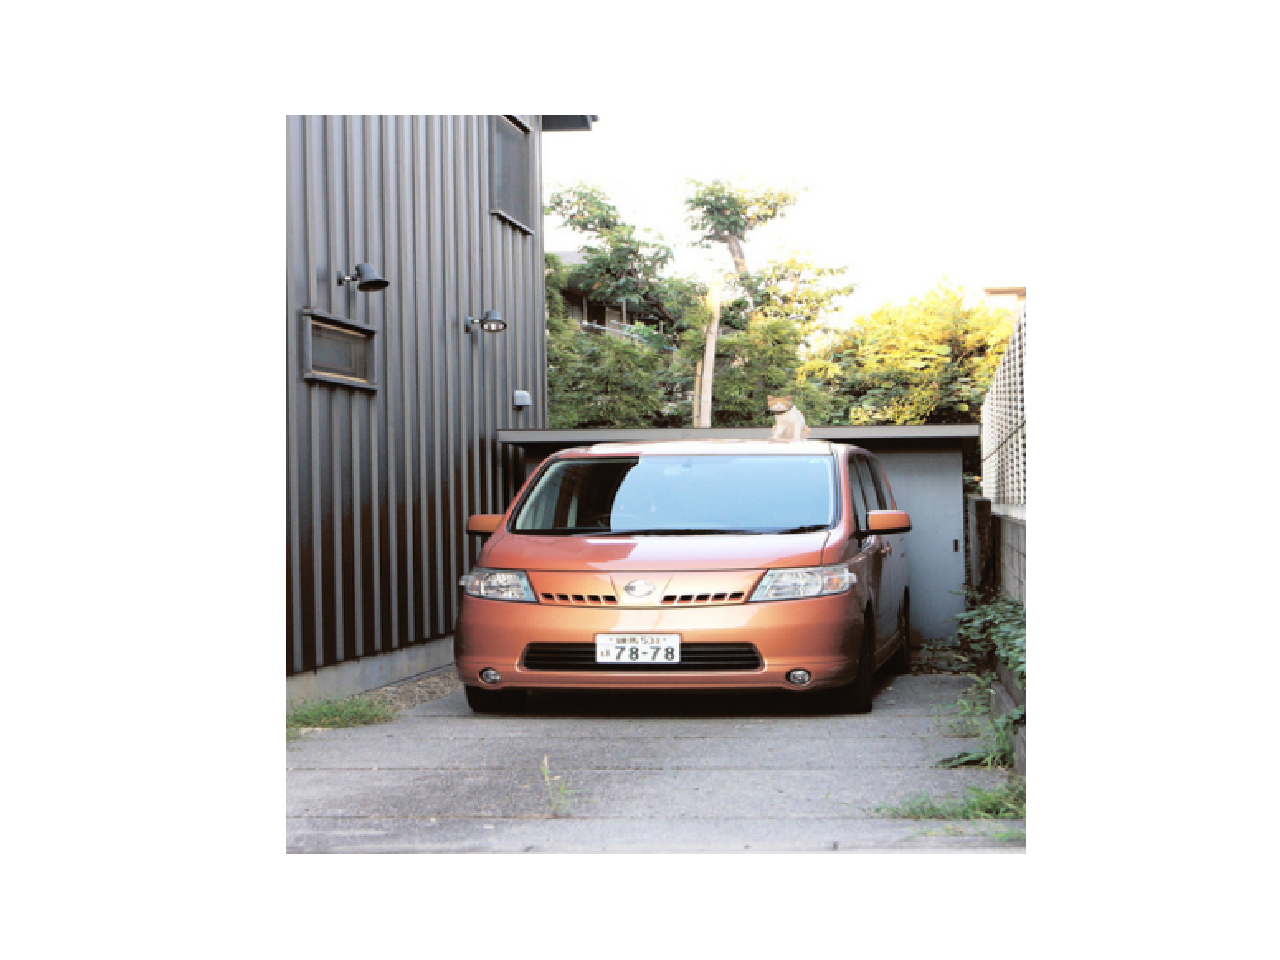

In [10]:
print(train[124][1])
myimshow(train[124][0])

In [12]:
#function that takes in the training, validation set question answer information and returns a vocabulary
#dictionary that maps word to a number

def get_vocab(dataloader):
    #get all questions from dataloader
    questions = []
    
    for data in dataloader: 
        for qa in data[1]:
            questions.append(qa[0])
            
    vocab = {}
    counter = 0 
    for question in questions:
        for word in question.split(" "):
            if word not in vocab: 
                vocab[word] = counter
                counter = counter + 1
    return vocab

train_vocab = get_vocab(train.get_qa())
val_vocab = get_vocab(val.get_qa())

print(len(train_vocab))

13744
